# Transfer learning for cats vs. dogs classification

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import adam
from keras import applications
from keras import backend as K

Using TensorFlow backend.


In this notebook we will use labeled images of cats and dogs to train a classifier able to distinguish between them. This is a task which, like many others in computer vision, we have learned how to master in the few past years, mainly because of *convolutional neural networks*.

There has been a [competition on Kaggle](https://www.kaggle.com/c/dogs-vs-cats) for this, back in 2014. Pierre Sermanet, a student of Yann LeCun, took 1st place, with an impressive 98.9% of accuracy on the test set. He briefly explains how he did it in this [Google+ post](https://plus.google.com/+PierreSermanet/posts/GxZHEH9ynoj):

> I just won the Dogs vs. Cats Kaggle competition, using the deep learning library I wrote during my PhD: OverFeat http://cilvr.nyu.edu/doku.php?id=code:start
>
> My system was pre-trained on ImageNet (ILSVRC12 classification dataset) and subsequently refined on the cats and dogs data. I limited my number of submissions to 5 to avoid test set tuning and obtained 1st place against 215 other teams with 98.9% accuracy.

But what exactly does it mean to *pre-train* a model? Well, let's figure out!

## Loading the data

We are going to use the data from the Kaggle contest. The dataset is quite big: there are 25000 training samples, and 12500 test samples, all of different sizes. We are thus going to work with only a few of them: we are taking 3000 samples from the training set, and using 2000 of them for training and 1000 for validation.

**BEFORE PROCEEDING**: please download the smaller dataset [here](https://www.dropbox.com/s/teiafmdpt49pddd/cats_and_dogs_small.zip?dl=0) and extract inside the `lec7/mldata` folder.

Let's load the data - Keras has some nice routines for that purpose. We start by loading a single image, just to see how it looks like (try changing the filename to see some others). Note we are doing color images, and thus working with 3-dimensional arrays.

array size: (396, 312, 3)


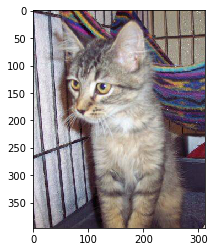

In [2]:
# Load image and transform it to a Numpy array
img = load_img("mldata/cats_and_dogs_small/train/cats/cat.2.jpg")
x = img_to_array(img)
print("array size:", x.shape)

# Show image
plt.imshow(x / 255.);

Next we specify some training parameters, and create a *generator* for the data, by using a quite convenient tool from Keras known as `ImageDataGenerator`. Essentially it iterates through the images in the directory, and preprocess them for us.

Below, we are rescaling each of the images, so that each pixel intensity goes from 0 to 1 instead of 0 to 255; and also adding some noise to the image so that the classifier becomes more robust, a technique known as *data augmentation*.

In [3]:
# Parameters
batch_size = 16
epochs = 20

n_train_samples = 2000
n_valid_samples = 1000
img_width, img_height = 150, 150

# Set up generator for training and validation images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory("mldata/cats_and_dogs_small/train",
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode="binary")

test_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = test_datagen.flow_from_directory("mldata/cats_and_dogs_small/valid",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training a CNN from scratch

Finally we will write down our neural network using Keras and train it. Below we use a neural network with 3 convolutional layers, which are supposed to learn relevant features, and 2 more dense layers, that will use the learned features to classify the image as a cat or a dog.

In [5]:
# Specify network architecture: 3 conv. layers w/ ReLU activations + 2 dense layers
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
__________

Let's fit our model now.

In [6]:
# Fit our model
#model.fit_generator(
    #train_generator,
    #steps_per_epoch=n_train_samples // batch_size,
    #epochs=epochs,
    #validation_data=valid_generator,
    #validation_steps=n_valid_samples // batch_size)

#model.save_weights("mldata/cnn_catsvsdogs.h5")

In [7]:
# (or if you don't want to wait you can't just load the weights below)
model.load_weights("mldata/cnn_catsvsdogs.h5")

Whew, that took a long time (unless you have a GPU!). If only we could use weights that we already trained on other datasets...

Let's see what's the accuracy we get on the test set:

In [8]:
test_loss, test_acc = model.evaluate_generator(valid_generator, steps=n_valid_samples//batch_size)
print("accuracy on test set:", test_acc)

accuracy on test set: 0.7762096774193549


Not bad -- with such accuracy we would be among the top half in the Kaggle contest (see ref. 1).

## Using pre-trained model

Training our CNN took a very long time. What if we replace it by another one, which was trained in a *similar dataset*? After all, the important features should be more or less the same, right?

People have been using lots of computational resources, training very deep networks over huge datasets. Luckily they have made their weights available, so we can use them! Below we gonna use a 16-layer convolutional neural network that was trained over the Imagenet dataset, known as [VGG-16](http://www.robots.ox.ac.uk/%7Evgg/research/very_deep/).

![VGG16](vgg16.png)

Let's do it in steps: first we load the VGG16 network, without the last final classifier layer (`include_top=False`).

In [9]:
# Load VGG16 weights
vgg16 = applications.VGG16(include_top=False, weights="imagenet")

Then we create generators as before (now without any data augmentation)  and run our samples through the VGG16 network.

In [11]:
# Parameters
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            print(f"{i * batch_size} samples generated for {directory}")
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [12]:
# This makes take a while...
n_train_samples = 1000
n_valid_samples = 500

train_features, train_labels = extract_features("mldata/cats_and_dogs_small/train", n_train_samples)
valid_features, valid_labels = extract_features("mldata/cats_and_dogs_small/valid", n_valid_samples)
print(f"train_features: {train_features.shape}")
print(f"valid_features: {valid_features.shape}")

Found 2000 images belonging to 2 classes.
1000 samples generated for mldata/cats_and_dogs_small/train
Found 1000 images belonging to 2 classes.
500 samples generated for mldata/cats_and_dogs_small/valid
train_features: (1000, 4, 4, 512)
valid_features: (500, 4, 4, 512)


Let's try to understand what the VGG16 network is doing. First let's see what the output looks like.

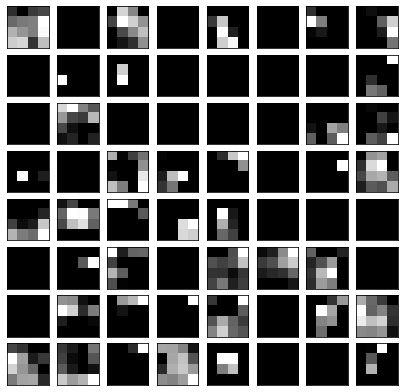

In [16]:
fig, axs = plt.subplots(8, 8, figsize=(7, 7))
for i in range(64):
    axs[i // 8, i % 8].imshow(train_features[0, :, :, i], cmap="gray")
    axs[i // 8, i % 8].get_xaxis().set_visible(False)
    axs[i // 8, i % 8].get_yaxis().set_visible(False)
fig.subplots_adjust(hspace=0.1)

It consists of 512 images of size 4x4, but looking at them doesn't reveal us much... Let us look at the output of the layers one by one.

In [17]:
# Create function that reads image and returns each layer output
input_img = vgg16.input
outputs = [layer.output for layer in vgg16.layers][1:]
functors = [K.function([input_img], [out]) for out in outputs]

# Input first image in the training set to this function
img_generator = datagen.flow_from_directory(
    "mldata/cats_and_dogs_small/train",
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False
)
img_generator.reset()
img = img_generator.next()

layer_outputs = [func([img])[0] for func in functors]
for i in range(len(layer_outputs)):
    print("layer %d shape: %s" % (i, layer_outputs[i].shape))

Found 2000 images belonging to 2 classes.
layer 0 shape: (1, 150, 150, 64)
layer 1 shape: (1, 150, 150, 64)
layer 2 shape: (1, 75, 75, 64)
layer 3 shape: (1, 75, 75, 128)
layer 4 shape: (1, 75, 75, 128)
layer 5 shape: (1, 37, 37, 128)
layer 6 shape: (1, 37, 37, 256)
layer 7 shape: (1, 37, 37, 256)
layer 8 shape: (1, 37, 37, 256)
layer 9 shape: (1, 18, 18, 256)
layer 10 shape: (1, 18, 18, 512)
layer 11 shape: (1, 18, 18, 512)
layer 12 shape: (1, 18, 18, 512)
layer 13 shape: (1, 9, 9, 512)
layer 14 shape: (1, 9, 9, 512)
layer 15 shape: (1, 9, 9, 512)
layer 16 shape: (1, 9, 9, 512)
layer 17 shape: (1, 4, 4, 512)


Change the value of `layer` below, from 0 to 17.

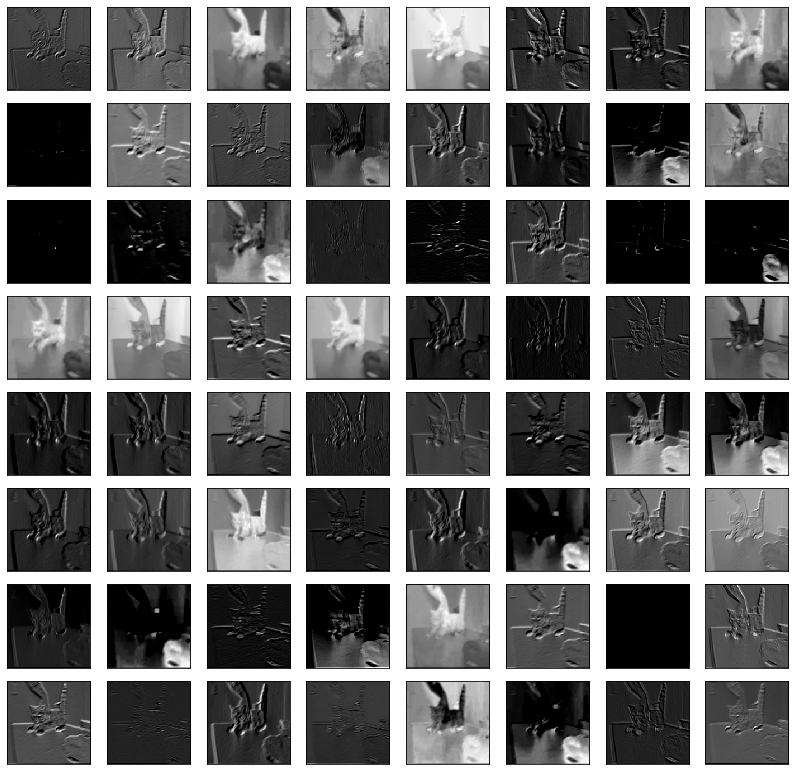

In [18]:
layer = 1

fig, axs = plt.subplots(8, 8, figsize=(14, 14))
for i in range(64):
    axs[i // 8, i % 8].imshow(layer_outputs[layer][0, :, :, i], cmap="gray")
    axs[i // 8, i % 8].get_xaxis().set_visible(False)
    axs[i // 8, i % 8].get_yaxis().set_visible(False)
fig.subplots_adjust(hspace=0.1)

We can understand each layer of a CNN as performing multiple image processing tasks in parallel - detecting edges, sharpening, blurring - [by doing convolutions with the learned filters](https://en.wikipedia.org/wiki/Kernel_(image_processing)). These tasks are performed not on the original image, but on the output of the previous layer; that's why the output of the rightmost layers become very hard to interpret.

Which task is performed depends on which filter is used. Here we are using the filters embedded on VGG16, but in principle we could learn them, if we were to train a CNN from scratch.

An interesting exercise, which provides a way of interpreting the output of the rightmost layers, is to find the image [which maximizes the activation of a certain filter](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html).

Finally, we take the output of the VGG16 network and plug it into the 2-layer classifier we had before.

In [19]:
from keras.optimizers import rmsprop

model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=rmsprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


Let's fit it!

In [20]:
model.fit(
    train_features, train_labels,
    epochs = 20,
    batch_size = 16,
    validation_data = (valid_features, valid_labels)
)

Instructions for updating:
Use tf.cast instead.
Train on 1000 samples, validate on 500 samples
Epoch 1/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6870 - acc: 0.6160 - val_loss: 0.5318 - val_acc: 0.7660
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4982 - acc: 0.7630 - val_loss: 0.4239 - val_acc: 0.8420
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4231 - acc: 0.8070 - val_loss: 0.3672 - val_acc: 0.8620
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3620 - acc: 0.8400 - val_loss: 0.3325 - val_acc: 0.8840
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3332 - acc: 0.8530 - val_loss: 0.3124 - val_acc: 0.8800
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2982 - acc: 0.8930 - val_loss: 0.2955 - val_acc: 0.8920
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2701 - acc: 0.8930 - va

In [21]:
test_loss, test_acc = model.evaluate(valid_features, valid_labels)
print("accuracy on test set:", test_acc)

500/500 [==============================] - 0s 278us/step
accuracy on test set: 0.9


That looks good no? And definitely much faster :-)

Found 1000 images belonging to 2 classes.


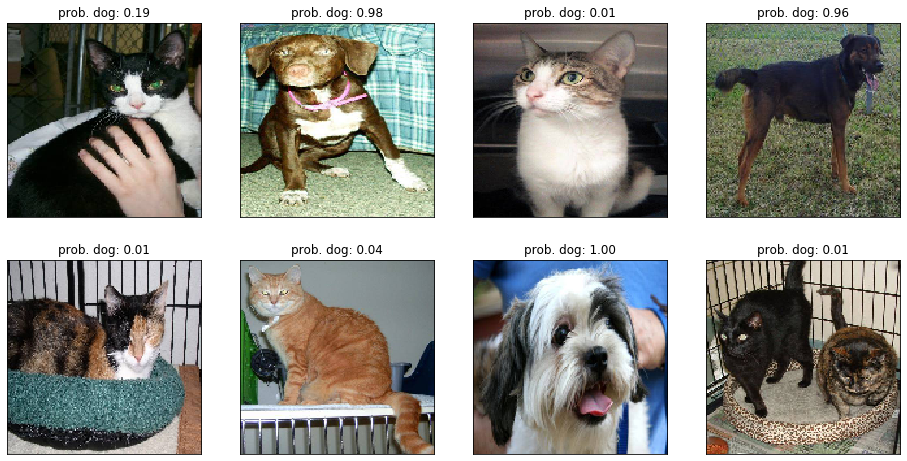

In [23]:
# Load 8 images at random, pass them through VGG16 and then through classifier
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory("mldata/cats_and_dogs_small/valid",
                         target_size=(img_width, img_height),
                         batch_size=8,
                         class_mode="binary")
batch = generator.next()
features = vgg16.predict(batch[0])
probs = model.predict_proba(features)

# Show images together with probabilities
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    axs[i // 4, i % 4].imshow(batch[0][i])
    axs[i // 4, i % 4].set_title("prob. dog: %.2f" % (probs[i]))
    
    axs[i // 4, i % 4].get_xaxis().set_visible(False)
    axs[i // 4, i % 4].get_yaxis().set_visible(False)

## References

1. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
2. https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d
3. https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
4. https://github.com/abursuc/dldiy-practicals/blob/master/10_05_lesson1.ipynb
5. https://github.com/fastai/courses/blob/master/deeplearning1/nbs/dogs_cats_redux.ipynb
6. http://www.cs.toronto.edu/~frossard/post/vgg16/
7. https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/